## NECESSARY IMPORTS AND VARIABLES

In [1]:

import tensorflow as tf
tf.config.list_physical_devices('GPU')
print(tf.__version__)

2.10.1


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.__version__

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(device_lib.list_local_devices())

#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11559820406071068412
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5718933504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6911598492545823780
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Found GPU at: /device:GPU:0


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image


import  cv2#, time
import os
#from albumentations import (Compose, HorizontalFlip, RandomRotate90, MotionBlur)
from keras.backend import clear_session

from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [6]:
batch_size = 16
img_height = 224
img_width = 224
SIZE = 224
num_channels = 3 # RGB
#labels = ['No_Billboard', 'Billboard']
INPUT_SHAPE = (img_height, img_width)
SHAPE = (img_height, img_width, num_channels)

data_dir_path = "/python_programming/FYP_2022/billboard_dataset/output1/"

dataset = []  #Many ways to handle data, you can use pandas.
label = []  #Place holders to define add labels. We will add 0 to all no_billboards  images and 1 to billboards.

## LOADING IN THE DATA

In [7]:
no_bilboard_images = os.listdir(data_dir_path + 'No_Billboard/')
for i, image_name in enumerate(no_bilboard_images):    #Remember enumerate method adds a counter and returns the enumerate object

    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(data_dir_path + 'No_Billboard/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1
billboard_images = os.listdir(data_dir_path + 'Billboard/')
for i, image_name in enumerate(billboard_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(data_dir_path + 'Billboard/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

dataset = np.array(dataset)
label = np.array(label)

(3020, 224, 224, 3)
(3020,)
Label for this image is:  1


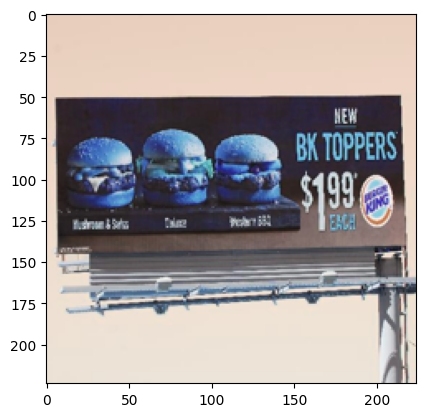

In [8]:
print(dataset.shape)
print(label.shape)


#Sanity check, view random few mages
import random
import numpy as np
image_number = random.randint(0, len(dataset)-1)
plt.imshow(np.reshape(dataset[image_number], (224, 224, 3)))
print("Label for this image is: ", label[image_number])

In [9]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

#from keras.utils import normalize
#X_train = normalize(X_train, axis=1)
#X_test = normalize(X_test, axis=1)
X_train = X_train / 255.
X_test = X_test / 255.

print(X_train.shape, '|', y_train.shape)
print(X_test.shape, '|', y_test.shape)


(2416, 224, 224, 3) | (2416,)
(604, 224, 224, 3) | (604,)


## TRAINING MODEL

In [ ]:
model_save_name = 'VGG19classifierkfoldabl.pt'
path = f"/python_programming/FYP_2022/Models/{model_save_name}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    verbose= 1,
    filepath=path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

base model without ablation

In [ ]:
base_VGG_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape= (img_height, img_width, num_channels),
    include_top=False)  # Do not include the ImageNet classifier at the top.
for layer in base_VGG_model.layers[0:5]:

    layer.trainable = False

baseline_model = tf.keras.models.Sequential(base_VGG_model.layers[:-2])
baseline_model.add(keras.layers.Conv2D(512, (3,3), activation='relu'))
baseline_model.add(keras.layers.Flatten())
baseline_model.add(keras.layers.Dense(1024, activation='relu'))
baseline_model.add(keras.layers.Dropout(0.5))
baseline_model.add(keras.layers.Dense(1024, activation='relu'))
baseline_model.add(keras.layers.Dense(2, activation='softmax'))

In [ ]:
# Baseline model (without ablation)
baseline_acc = baseline_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= 0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
#compile_and_train(baseline_model, X_train, y_train, X_test, y_test)#Adam()
print(baseline_model.summary)
baseline_model.fit(X_train, y_train, epochs=10, batch_size=12, validation_data=(X_test, y_test))
test_loss, test_acc = baseline_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x00000207B9A77DF0>>
Epoch 1/10
202/202 [==============================] - 58s 202ms/step - loss: 0.5536 - accuracy: 0.7094 - val_loss: 0.4119 - val_accuracy: 0.8344
Epoch 2/10
202/202 [==============================] - 37s 182ms/step - loss: 0.3519 - accuracy: 0.8597 - val_loss: 0.2625 - val_accuracy: 0.8940
Epoch 3/10
202/202 [==============================] - 37s 182ms/step - loss: 0.2412 - accuracy: 0.9048 - val_loss: 0.1927 - val_accuracy: 0.9255
Epoch 4/10
202/202 [==============================] - 37s 183ms/step - loss: 0.1705 - accuracy: 0.9392 - val_loss: 0.1604 - val_accuracy: 0.9338
Epoch 5/10
202/202 [==============================] - 37s 182ms/step - loss: 0.1433 - accuracy: 0.9450 - val_loss: 0.1383 - val_accuracy: 0.9470
Epoch 6/10
202/202 [==============================] - 37s 182ms/step - loss: 0.1164 - accuracy: 0.9611 - val_loss: 0.1294 - val_accuracy: 0.9520
Epoch 7/10
202/202 [============

In [ ]:
tf.keras.backend.clear_session()

----------------------------------------------vgg19 basemodel with ablation (10%, 25%, 50%)---------------------------------------------------------------


10% ablation in 'block1_conv1', 'block2_conv1'


In [ ]:
from tensorflow.keras import  models
#datasets
# Load pre-trained VGG19 model
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
model = models.Sequential([
    vgg19,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2)  # 2 classes for advert no-advert
])

# Define ablation function
def ablate_layer(layer, p):
    if isinstance(layer, tf.keras.layers.Conv2D):
        n_filters = layer.kernel.shape[-1]
        n_ablated = int(p * n_filters)
        indices = tf.random.shuffle(tf.range(n_filters))[:n_ablated]
        zeros = tf.zeros_like(layer.kernel[..., 0])
        for index in indices:
            layer.kernel[..., index].assign(zeros)

# Freeze layers above a specified layer
def freeze_layers(model, layer_name):
    freeze = False
    for layer in model.layers:
        if freeze:
            layer.trainable = False
        if layer.name == layer_name:
            freeze = True



# Define training function
def train(model, X_train, y_train, epochs, batch_size, val_data, path):#, X_test, y_test
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= 0.0001),#'adam', #
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data =  val_data)#, validation = (X_test, y_test))
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')
    model.save(os.path.join(path, 'ALOS_VGG19ADNET_model_ablb1c1_x.h5'))
    #model.save(os.path.join(path, 'ALOS_VGG19ADNET_model_ablb2c1.h5'))


In [ ]:
# Ablation and recovery training
layer_names = ['block1_conv1']#, 'block2_conv1']  # Layers to ablate
for layer_name in layer_names:
    #for i in range(5):  # Number of iterations
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())
        layer = model_copy.get_layer('vgg19').get_layer(layer_name)
        ablate_layer(layer, 0.10)  # Ablate 10% of filters in the layer
        freeze_layers(model_copy, layer_name)  # Freeze layers above the ablated layer
        train(model_copy, X_train, y_train, epochs=5, batch_size=8, val_data =(X_test, y_test), path = f"/python_programming/FYP_2022/Models/model/ablationvgg19/")#,   # Recovery training for 5 epochs

Epoch 1/5
302/302 [==============================] - 78s 219ms/step - loss: 0.3892 - accuracy: 0.8386 - val_loss: 0.2819 - val_accuracy: 0.8858
Epoch 2/5
302/302 [==============================] - 64s 213ms/step - loss: 0.1933 - accuracy: 0.9296 - val_loss: 0.2216 - val_accuracy: 0.9106
Epoch 3/5
302/302 [==============================] - 65s 214ms/step - loss: 0.1327 - accuracy: 0.9532 - val_loss: 0.1339 - val_accuracy: 0.9536
Epoch 4/5
302/302 [==============================] - 66s 217ms/step - loss: 0.1012 - accuracy: 0.9685 - val_loss: 0.1375 - val_accuracy: 0.9503
Epoch 5/5
19/19 [==============================] - 15s 536ms/step - loss: 0.1111 - accuracy: 0.9586
Test accuracy: 0.9586092829704285


In [ ]:
# Ablation and recovery training
layer_names = ['block2_conv1']# Layers to ablate
for layer_name in layer_names:
    #for i in range(5):  # Number of iterations
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())
        layer = model_copy.get_layer('vgg19').get_layer(layer_name)
        ablate_layer(layer, 0.10)  # Ablate 10% of filters in the layer
        freeze_layers(model_copy, layer_name)  # Freeze layers above the ablated layer
        train(model_copy, X_train, y_train, epochs=5, batch_size=8, val_data =(X_test, y_test), path = f"/python_programming/FYP_2022/Models/model/ablationvgg19/")#,   # Recovery training for 5 epochs

Epoch 1/5
302/302 [==============================] - 79s 220ms/step - loss: 0.4085 - accuracy: 0.8365 - val_loss: 0.2901 - val_accuracy: 0.8874
Epoch 2/5
302/302 [==============================] - 66s 219ms/step - loss: 0.2049 - accuracy: 0.9292 - val_loss: 0.1755 - val_accuracy: 0.9354
Epoch 3/5
302/302 [==============================] - 66s 218ms/step - loss: 0.1337 - accuracy: 0.9545 - val_loss: 0.1383 - val_accuracy: 0.9487
Epoch 4/5
302/302 [==============================] - 66s 218ms/step - loss: 0.0981 - accuracy: 0.9677 - val_loss: 0.1074 - val_accuracy: 0.9636
Epoch 5/5
19/19 [==============================] - 15s 519ms/step - loss: 0.0949 - accuracy: 0.9702
Test accuracy: 0.9701986908912659


In [10]:

#from tf.keras.models import load_model

path = f"/python_programming/FYP_2022/Models/model/ablationvgg19/"

new_model = tf.keras.models.load_model(os.path.join(path, 'ALOS_VGG19ADNET_model_10ablb1c1.h5'))

test_loss, test_acc = new_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test Loss: {test_loss} ')


19/19 [==============================] - 22s 515ms/step - loss: 0.1111 - accuracy: 0.9586
Test accuracy: 0.9586092829704285, Test Loss: 0.11112936586141586 


25% ablation in 'block1_conv1', 'block2_conv1'

In [ ]:
from tensorflow.keras import datasets, models

# Load pre-trained VGG19 model
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
model = models.Sequential([
    vgg19,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2)  # 2 classes for advert no-advert
])

# Define ablation function
def ablate_layer(layer, p):
    if isinstance(layer, tf.keras.layers.Conv2D):
        n_filters = layer.kernel.shape[-1]
        n_ablated = int(p * n_filters)
        indices = tf.random.shuffle(tf.range(n_filters))[:n_ablated]
        zeros = tf.zeros_like(layer.kernel[..., 0])
        for index in indices:
            layer.kernel[..., index].assign(zeros)

# Freeze layers above a specified layer
def freeze_layers(model, layer_name):
    freeze = False
    for layer in model.layers:
        if freeze:
            layer.trainable = False
        if layer.name == layer_name:
            freeze = True

# Define training function
def train(model, X_train, y_train, epochs, batch_size, val_data, path):
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= 0.0001),#'adam', #
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=val_data)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')
    #model.save(os.path.join(path, 'ALOS_VGG19ADNET_model_25ablb1c1.h5'))
    model.save(os.path.join(path, 'ALOS_VGG19ADNET_model_25ablb2c1.h5'))
    tf.keras.backend.clear_session()



In [ ]:
# Ablation and recovery training
layer_names = ['block1_conv1']#, 'block2_conv1']  # Layers to ablate
for layer_name in layer_names:
    #for i in range(5):  # Number of iterations
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())
        layer = model_copy.get_layer('vgg19').get_layer(layer_name)
        ablate_layer(layer, 0.25)  # Ablate 25% of filters in the layer
        freeze_layers(model_copy, layer_name)  # Freeze layers above the ablated layer
        train(model_copy, X_train, y_train, epochs=5, batch_size=8, val_data = ( X_test, y_test),  path = f"/python_programming/FYP_2022/Models/model/ablationvgg19/")  # Recovery training for 5 epochs

Epoch 1/5
302/302 [==============================] - 69s 224ms/step - loss: 0.4204 - accuracy: 0.8142 - val_loss: 0.2614 - val_accuracy: 0.9056
Epoch 2/5
302/302 [==============================] - 66s 220ms/step - loss: 0.2076 - accuracy: 0.9247 - val_loss: 0.1818 - val_accuracy: 0.9321
Epoch 3/5
302/302 [==============================] - 64s 213ms/step - loss: 0.1446 - accuracy: 0.9495 - val_loss: 0.1388 - val_accuracy: 0.9470
Epoch 4/5
302/302 [==============================] - 67s 223ms/step - loss: 0.1108 - accuracy: 0.9607 - val_loss: 0.1402 - val_accuracy: 0.9536
Epoch 5/5
19/19 [==============================] - 11s 571ms/step - loss: 0.1074 - accuracy: 0.9586
Test accuracy: 0.9586092829704285


In [ ]:
# Ablation and recovery training
tf.keras.backend.clear_session()
layer_names = ['block2_conv1']  # Layers to ablate
for layer_name in layer_names:
    #for i in range(5):  # Number of iterations
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())
        layer = model_copy.get_layer('vgg19').get_layer(layer_name)
        ablate_layer(layer, 0.25)  # Ablate 25% of filters in the layer
        freeze_layers(model_copy, layer_name)  # Freeze layers above the ablated layer
        train(model_copy, X_train, y_train, epochs=5, batch_size=8, val_data = ( X_test, y_test),  path = f"/python_programming/FYP_2022/Models/model/ablationvgg19/")  # Recovery training for 5 epochs

Epoch 1/5
302/302 [==============================] - 48s 121ms/step - loss: 0.4503 - accuracy: 0.8104 - val_loss: 0.3231 - val_accuracy: 0.8825
Epoch 2/5
302/302 [==============================] - 32s 106ms/step - loss: 0.2429 - accuracy: 0.9106 - val_loss: 0.2306 - val_accuracy: 0.9123
Epoch 3/5
302/302 [==============================] - 33s 109ms/step - loss: 0.1707 - accuracy: 0.9354 - val_loss: 0.2049 - val_accuracy: 0.9205
Epoch 4/5
302/302 [==============================] - 33s 108ms/step - loss: 0.1291 - accuracy: 0.9545 - val_loss: 0.1460 - val_accuracy: 0.9470
Epoch 5/5
19/19 [==============================] - 7s 219ms/step - loss: 0.1291 - accuracy: 0.9536
Test accuracy: 0.9536423683166504


50% ablation in 'block1_conv1', 'block2_conv1'

In [ ]:
from tensorflow.keras import models

# Load pre-trained VGG19 model
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
model = models.Sequential([
    vgg19,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2)  # 2 classes for advert no-advert
])

# Define ablation function
def ablate_layer(layer, p):
    if isinstance(layer, tf.keras.layers.Conv2D):
        n_filters = layer.kernel.shape[-1]
        n_ablated = int(p * n_filters)
        indices = tf.random.shuffle(tf.range(n_filters))[:n_ablated]
        zeros = tf.zeros_like(layer.kernel[..., 0])
        for index in indices:
            layer.kernel[..., index].assign(zeros)

# Freeze layers above a specified layer
def freeze_layers(model, layer_name):
    freeze = False
    for layer in model.layers:
        if freeze:
            layer.trainable = False
        if layer.name == layer_name:
            freeze = True

# Define training function
def train(model, X_train, y_train, epochs, batch_size, val_data, path):#, X_test, y_test
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= 0.0001),#'adam', #
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data = val_data)#, validation = (X_test, y_test))
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')
    #model.save(os.path.join(path, 'ALOS_VGG19ADNET_model_50ablb1c1.h5'))
    model.save(os.path.join(path, 'ALOS_VGG19ADNET_model_50ablb2c1.h5'))
    tf.keras.backend.clear_session()


# Load dataset
#(train_images, train_labels), (_, _) = datasets.cifar10.load_data()
#train_images, train_labels = train_images / 255.0, train_labels.flatten()



In [ ]:
# Ablation and recovery training
tf.keras.backend.clear_session()
layer_names = ['block1_conv1']#, 'block2_conv1']  # Layers to ablate
for layer_name in layer_names:
    #for i in range(5):  # Number of iterations
        #model = tf.keras.models.clone_model(vgg19)
        #model.set_weights(vgg19.get_weights())
        #layer = model.get_layer(layer_name)
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())
        #layer = model_copy.get_layer(layer_name)
        layer = model_copy.get_layer('vgg19').get_layer(layer_name)
        ablate_layer(layer, 0.50)  # Ablate 25% of filters in the layer
        freeze_layers(model_copy, layer_name)  # Freeze layers above the ablated layer
        train(model_copy, X_train, y_train, epochs=5, batch_size=8, val_data = ( X_test, y_test),  path = f"/python_programming/FYP_2022/Models/model/ablationvgg19/")#  # Recovery training for 5 epochs

Epoch 1/5
302/302 [==============================] - 43s 109ms/step - loss: 0.4281 - accuracy: 0.8125 - val_loss: 0.2929 - val_accuracy: 0.8891
Epoch 2/5
302/302 [==============================] - 31s 103ms/step - loss: 0.2396 - accuracy: 0.9065 - val_loss: 0.1978 - val_accuracy: 0.9255
Epoch 3/5
302/302 [==============================] - 31s 104ms/step - loss: 0.1784 - accuracy: 0.9284 - val_loss: 0.1674 - val_accuracy: 0.9288
Epoch 4/5
302/302 [==============================] - 31s 104ms/step - loss: 0.1398 - accuracy: 0.9483 - val_loss: 0.1353 - val_accuracy: 0.9421
Epoch 5/5
19/19 [==============================] - 7s 222ms/step - loss: 0.1189 - accuracy: 0.9636
Test accuracy: 0.9635761380195618


In [ ]:
# Ablation and recovery training
tf.keras.backend.clear_session()
layer_names = ['block2_conv1']  # Layers to ablate
for layer_name in layer_names:
    #for i in range(5):  # Number of iterations
        #model = tf.keras.models.clone_model(vgg19)
        #model.set_weights(vgg19.get_weights())
        #layer = model.get_layer(layer_name)
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())
        #layer = model_copy.get_layer(layer_name)
        layer = model_copy.get_layer('vgg19').get_layer(layer_name)
        ablate_layer(layer, 0.50)  # Ablate 25% of filters in the layer
        freeze_layers(model_copy, layer_name)  # Freeze layers above the ablated layer
        train(model_copy, X_train, y_train, epochs=5, batch_size=8, val_data = ( X_test, y_test),  path = f"/python_programming/FYP_2022/Models/model/ablationvgg19/")#  # Recovery training for 5 epochs

Epoch 1/5
302/302 [==============================] - 43s 113ms/step - loss: 0.4460 - accuracy: 0.8022 - val_loss: 0.3488 - val_accuracy: 0.8526
Epoch 2/5
302/302 [==============================] - 32s 107ms/step - loss: 0.2455 - accuracy: 0.9019 - val_loss: 0.2076 - val_accuracy: 0.9139
Epoch 3/5
302/302 [==============================] - 32s 107ms/step - loss: 0.1735 - accuracy: 0.9325 - val_loss: 0.2028 - val_accuracy: 0.9073
Epoch 4/5
302/302 [==============================] - 32s 107ms/step - loss: 0.1358 - accuracy: 0.9520 - val_loss: 0.1610 - val_accuracy: 0.9371
Epoch 5/5
19/19 [==============================] - 7s 223ms/step - loss: 0.1327 - accuracy: 0.9520
Test accuracy: 0.9519867300987244


plot ablation training epoch accuray plot

In [ ]:
#from tf.keras.models import load_model

path = f"/python_programming/FYP_2022/Models/model/ablationvgg19/"

new_model = tf.keras.models.load_model(os.path.join(path, 'ALOS_VGG19ADNET_model_10ablb2c1.h5'))

test_loss, test_acc = new_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

5


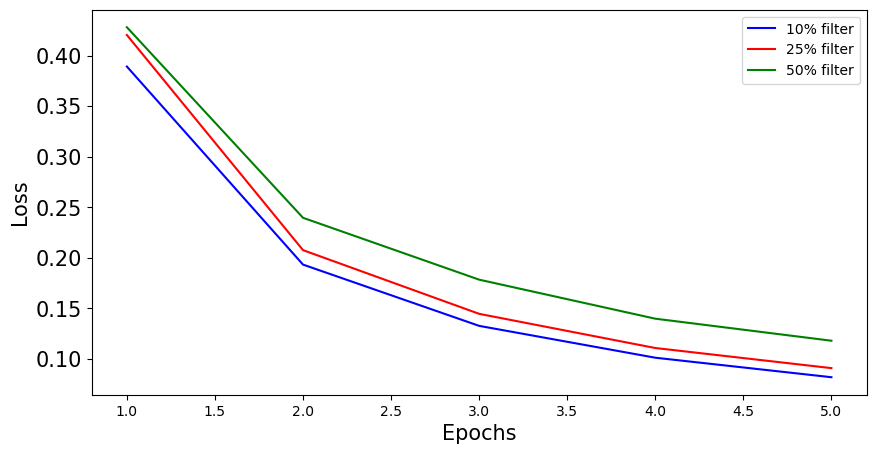

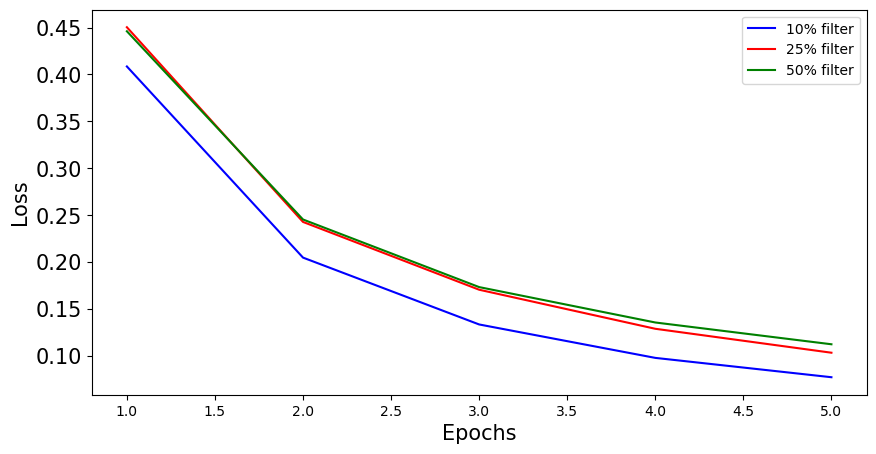

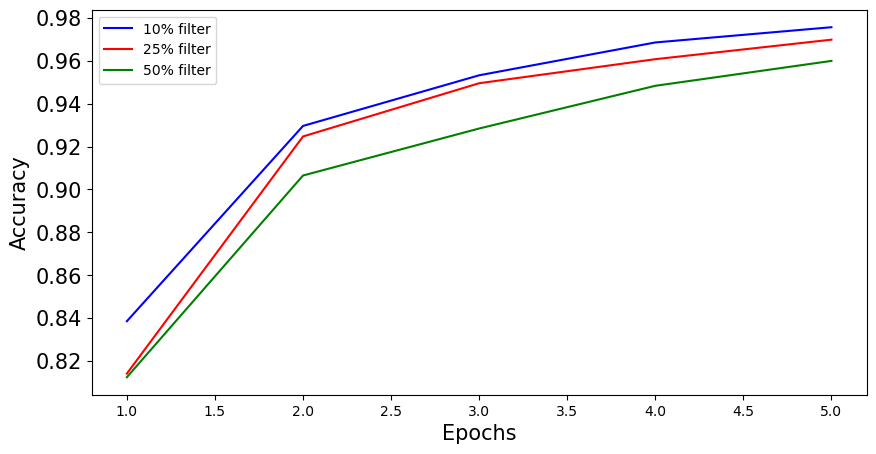

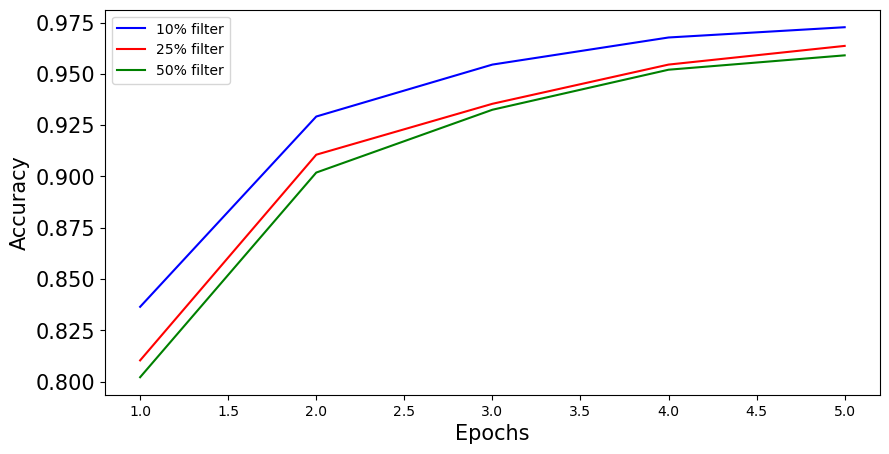

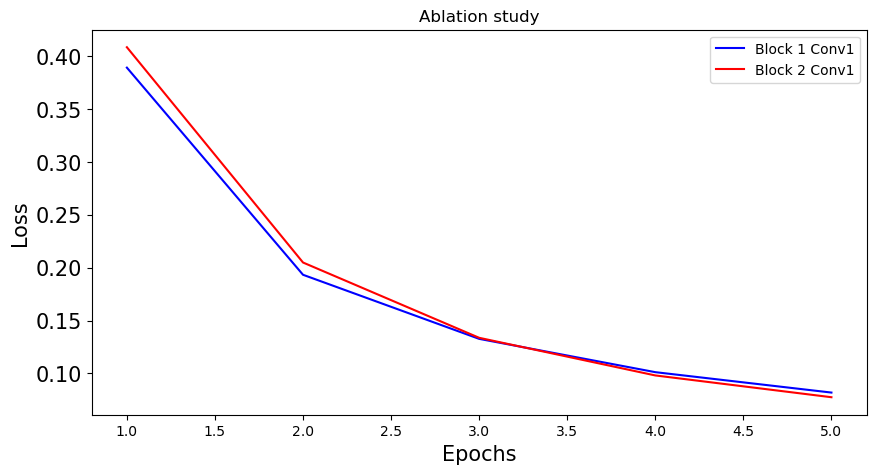

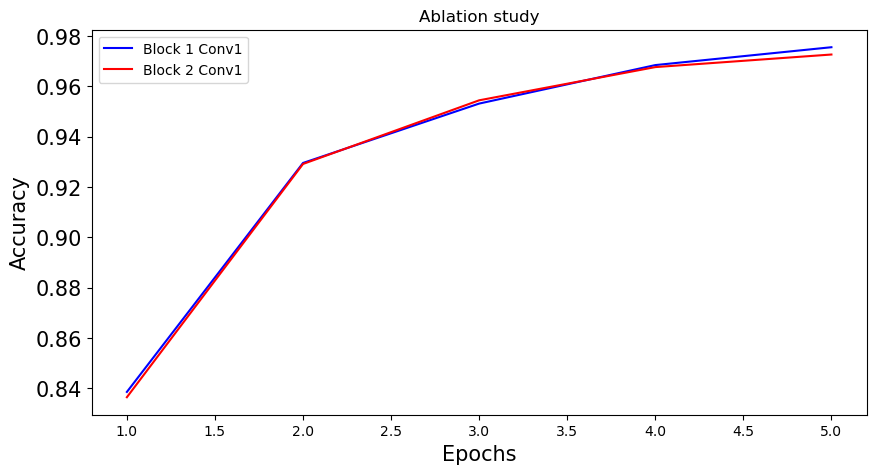

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


'''
Line Graph for IoU Values Across Frames
'''
# 					loss_b2c1	acc__b2c1	val_loss__b2c1	val_acc__b2c1

import pandas as pd

df_10 = pd.read_csv('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablationstudy_10.csv')
df_25 = pd.read_csv('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablationstudy_25.csv')
df_50 = pd.read_csv('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablationstudy_50.csv')

# Extract the IoU values and frame numbers from csv

epochs_10 = df_10['epoch'].tolist()
lossb1c1_10 = df_10['loss_b1c1'].tolist()
accb1c1_10 = df_10['acc_b1c1'].tolist()
#vallsb1c1 = df_10['val_loss_b1c1'].tolist()
#valaccb1c1 = df_10['val_acc_b1c1'].tolist()

lossb2c1_10 = df_10['loss_b2c1'].tolist()
accb2c1_10 = df_10['acc_b2c1'].tolist()
#vallsb2c1 = df_10['val_loss_b2c1'].tolist()
#valaccb2c1 = df_10['val_acc_b2c1'].tolist()

epochs_25 = df_25['epoch'].tolist()
lossb1c1_25 = df_25['loss_b1c1'].tolist()
accb1c1_25 = df_25['acc_b1c1'].tolist()
#vallsb1c1 = df_10['val_loss_b1c1'].tolist()
#valaccb1c1 = df_10['val_acc_b1c1'].tolist()

lossb2c1_25 = df_25['loss_b2c1'].tolist()
accb2c1_25 = df_25['acc_b2c1'].tolist()
#vallsb2c1 = df_10['val_loss_b2c1'].tolist()
#valaccb2c1 = df_10['val_acc_b2c1'].tolist()

epochs_50 = df_50['epoch'].tolist()
lossb1c1_50 = df_50['loss_b1c1'].tolist()
accb1c1_50 = df_50['acc_b1c1'].tolist()
#vallsb1c1 = df_10['val_loss_b1c1'].tolist()
#valaccb1c1 = df_10['val_acc_b1c1'].tolist()

lossb2c1_50 = df_50['loss_b2c1'].tolist()
accb2c1_50 = df_50['acc_b2c1'].tolist()
#vallsb2c1 = df_10['val_loss_b2c1'].tolist()
#valaccb2c1 = df_10['val_acc_b2c1'].tolist()

print(len(epochs)) #1572

#####################plot loss for block 1 with 10 % filter 25 % 50%  reduction #############################

plt.figure(figsize=(10, 5))
plt.plot(epochs_10, lossb1c1_10,  linestyle='-', color='b', label='10% filter')#marker='o',
plt.plot(epochs_25, lossb1c1_25,  linestyle='-', color='r', label='25% filter')#marker='o',
plt.plot(epochs_50, lossb1c1_50,  linestyle='-', color='g', label='50% filter')#marker='o',
#plt.title('Ablation study')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xticks( fontsize=10)#12#10#tick_positions, tick_labels,
plt.yticks(fontsize=15)
plt.legend()
plt.savefig('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablation_10_25_50_lssb1c1.jpg',  bbox_inches = 'tight')#, pad_inches = 0
plt.show()

#####################plot loss for block 2 with 10 % filter 25 % 50%  reduction #############################

plt.figure(figsize=(10, 5))
plt.plot(epochs_10, lossb2c1_10,  linestyle='-', color='b', label='10% filter')#marker='o',
plt.plot(epochs_25, lossb2c1_25,  linestyle='-', color='r', label='25% filter')#marker='o',
plt.plot(epochs_50, lossb2c1_50,  linestyle='-', color='g', label='50% filter')#marker='o',
#plt.title('Ablation study')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xticks( fontsize=10)#12#10#tick_positions, tick_labels,
plt.yticks(fontsize=15)
plt.legend()
plt.savefig('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablation_10_25_50_lssb2c1.jpg',  bbox_inches = 'tight')#, pad_inches = 0
plt.show()

#####################plot acc for block 1 with 10 % filter 25 % 50%  reduction #############################

plt.figure(figsize=(10, 5))
plt.plot(epochs_10, accb1c1_10,  linestyle='-', color='b', label='10% filter')#marker='o',
plt.plot(epochs_25, accb1c1_25,  linestyle='-', color='r', label='25% filter')#marker='o',
plt.plot(epochs_50, accb1c1_50,  linestyle='-', color='g', label='50% filter')#marker='o',
#plt.title('Ablation study')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.xticks( fontsize=10)#12#10#tick_positions, tick_labels,
plt.yticks(fontsize=15)
plt.legend()
plt.savefig('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablation_10_25_50_accb1c1.jpg',  bbox_inches = 'tight')#, pad_inches = 0
plt.show()

#####################plot acc for block 2 with 10 % filter 25 % 50%  reduction #############################

plt.figure(figsize=(10, 5))
plt.plot(epochs_10, accb2c1_10,  linestyle='-', color='b', label='10% filter')#marker='o',
plt.plot(epochs_25, accb2c1_25,  linestyle='-', color='r', label='25% filter')#marker='o',
plt.plot(epochs_50, accb2c1_50,  linestyle='-', color='g', label='50% filter')#marker='o',
#plt.title('Ablation study')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.xticks( fontsize=10)#12#10#tick_positions, tick_labels,
plt.yticks(fontsize=15)
plt.legend()
plt.savefig('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablation_10_25_50_accb2c1.jpg',  bbox_inches = 'tight')#, pad_inches = 0
plt.show()


#####plot loss for block1 and block2

plt.figure(figsize=(10, 5))
plt.plot(epochs, lossb1c1,  linestyle='-', color='b', label='Block 1 Conv1')#marker='o',
plt.plot(epochs, lossb2c1,  linestyle='-', color='r', label='Block 2 Conv1')#marker='o',
plt.title('Ablation study')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xticks( fontsize=10)#12#10#tick_positions, tick_labels,
plt.yticks(fontsize=15)
plt.legend()
#plt.savefig('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablation_50_lss.jpg',  bbox_inches = 'tight', pad_inches = 0)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accb1c1,  linestyle='-', color='b', label='Block 1 Conv1')#marker='o',
plt.plot(epochs, accb2c1,  linestyle='-', color='r', label='Block 2 Conv1')#marker='o',
plt.title('Ablation study')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.xticks( fontsize=10)#12#10#tick_positions, tick_labels,
plt.yticks(fontsize=15)
plt.legend()
#plt.savefig('/python_programming/FYP_2022/testresult/ablationstudy_csv/ablation_50_acc.jpg',  bbox_inches = 'tight', pad_inches = 0)
plt.show()



## PREDICTIONS AND VISUALISATION OF MISCLASSIFIED IMAGES

In [ ]:
predictions = new_model.predict(X_test)
actual_ylabel = y_test

#print("The prediction for this image is: ", predictions)
print("The actual label for this image is: ", actual_ylabel)

y_hat = np.argmax(predictions, axis = 1) # We take the highest probability
print('prediction label:', y_hat)

#Compare the predictions and labels and get the accuracy
accuracy = np.mean(np.equal(actual_ylabel, y_hat))
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Compare y_hat to y_val
misclassified = []
label_comparison =  actual_ylabel == y_hat
misclassified = np.where(label_comparison == False)[0]  # Get the indices of misclassified images
print('misclassified indices:',misclassified)
print('no of missclassification:', len(misclassified))
plt.figure(figsize=(25, 25))
for i, index in enumerate(misclassified):
    ax =plt.subplot(9, 7, i+1)
    plt.imshow(X_test[index])
    plt.title("True label: {} \n Predicted label: {}".format(actual_ylabel[index], y_hat[index]))
    plt.axis('off')

Calculate the  evaluation metric: Recall, Precision, Accucracy

In [ ]:
pre = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()
acc = tf.keras.metrics.BinaryAccuracy()
rootmsqrerror = tf.keras.metrics.RootMeanSquaredError()
auc_roc = tf.keras.metrics.AUC()

In [ ]:
tf.math.confusion_matrix(
    y_test,
    y_hat,
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

In [ ]:
pre.update_state(y_test, y_hat)
rec.update_state(y_test, y_hat)
acc.update_state(y_test, y_hat)
rootmsqrerror.update_state(y_test, y_hat)
auc_roc.update_state(y_test, y_hat)



print(f'Precision:{pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')
print(f'RMSE:{rootmsqrerror.result().numpy()}')
print(f'AUC:{auc_roc.result().numpy()}')

f1_score = 2 * (pre.result().numpy() * rec.result().numpy()) / (pre.result().numpy() + rec.result().numpy())

print(f'F1score:{f1_score}')

In [ ]:
newtest = cv2.imread('/python_programming/FYP_2022/billboard_dataset/output1/Billboard/scene_1223.jpg')
plt.imshow(newtest)
plt.show()

resize_newtest = cv2.resize(newtest, (224, 224))
plt.imshow(resize_newtest)
plt.show()
pred_newtest = np.expand_dims(resize_newtest/255, 0)
#print(pred_newtest)

y_pred_newtest = new_model.predict(pred_newtest)
print(y_pred_newtest)
y_pred_newtest = np.argmax(y_pred_newtest, axis = 1)
print(y_pred_newtest)

if y_pred_newtest > 0.5:
  print('Predicted class belongs to billboard class')

else:
  print('Predicted class belongs to no billboad class')

basemodel with ablation ver 1

In [ ]:

def modify_vgg19_model(reduction_percent):
    original_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = original_vgg19.input
    y = x

    for layer in original_vgg19.layers:
        layer.trainable = False
        if 'conv' in layer.name:
            filters = layer.filters
            #print(filters)
            reduced_filters = int(filters * (1 - reduction_percent))
            #print(reduced_filters)
            config = layer.get_config()
            config['filters'] = reduced_filters
            y = tf.keras.layers.Conv2D.from_config(config)(y)
        else:
            y = layer(y)

    y = Flatten()(y)
    y = Dense(1024, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(1024, activation='relu')(y)
    y = Dense(2, activation='softmax')(y)

    modified_model = Model(inputs=x, outputs=y)
    return modified_model

In [ ]:
def compile_and_train(model, X_train, y_train, X_test, y_test, epochs=5, batch_size=12): #batch_size = 64
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= 0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])#(optimizer=Adam(), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
    print(model.summary)
    tf.keras.utils.plot_model(model, show_shapes=True)#show_shapes=True
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')
    return test_acc


# Ablated models
ablation_percentages = 0.1 #[0.1, 0.25, 0.5]
#for reduction in ablation_percentages:
print(f'\nTraining model with {int(ablation_percentages*100)}% reduction in filters')
modified_model = modify_vgg19_model(ablation_percentages)
modified_acc = compile_and_train(modified_model, X_train, y_train, X_test, y_test)
print(f'Ablation {int(ablation_percentages*100)}% filters: {modified_acc}')


Training model with 10% reduction in filters
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
<bound method Model.summary of <keras.engine.functional.Functional object at 0x000001FA85BF8FA0>>
Epoch 1/5
202/202 [==============================] - 16s 77ms/step - loss: 0.6928 - accuracy: 0.5927 - val_loss: 0.6929 - val_accuracy: 0.5281
Epoch 2/5
202/202 [==============================] - 15s 74ms/step - loss: 0.6921 - accuracy: 0.5923 - val_loss: 0.6927 - val_accuracy: 0.5281
Epoch 3/5
202/202 [==============================] - 15s 75ms/step - loss: 0.6914 - accuracy: 0.5923 - val_loss: 0.6925 - val_accuracy: 0.5281
Epoch 4/5
202/202 [==============================] - 15s 74ms/step - loss: 0.6908 - accuracy: 0.5923 - val_loss: 0.6924 - val_accuracy: 0.5281
Epoch 5/5
202/

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/block1_conv1/Relu' defined at (most recent call last):
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sukri\AppData\Local\Temp\ipykernel_8752\2310691542.py", line 16, in <module>
      modified_acc = compile_and_train(modified_model, X_train, y_train, X_test, y_test)
    File "C:\Users\sukri\AppData\Local\Temp\ipykernel_8752\2310691542.py", line 5, in compile_and_train
      model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1606, in fit
      val_logs = self.evaluate(
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\sukri\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_1/block1_conv1/Relu'
OOM when allocating tensor with shape[32,57,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_22318]